In [2]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## DP-GMMのStanを用いた推定

note13-1と同じ一次元データを使います。

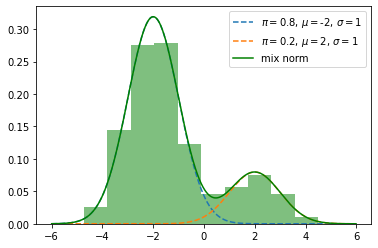

In [4]:
from scipy.stats import norm # 正規分布

def calc_mix_pdf(k_size, x, pi_list, mu_list, sigma_list):
    pdf = np.zeros(len(x)) # x の範囲分初期化する
    for k in range(k_size):
        pdf += pi_list[k] * norm(loc=mu_list[k], scale=sigma_list[k]).pdf(x) # 上に加算することに注意
    return pdf

# 正規分布が2つで、指定した重みの w1 * Norm(mu1, sigma1) + w2 * Norm(mu2, sigma2) の混合正規分布を考える
# 混合分布のイメージを確かにするために、適当にパラメータは変えてみてください。
pi_list    = [0.8, 0.2] # 混合比率を合計が1になるように設定。8:2とする
mu_list    = [-2, 2]    # 平均の真のパラメータ
sigma_list = [1,  1]    # 

N = 1000 # 生成するデータ数(サンプル数)
K = len(pi_list) # 混合数

data = [] # 生成したデータを入れるリスト

# 基本的に note2-2 のガウス分布に pi を加えた。
x = np.arange(-6, 6, 0.01)
for _pi, _mu, _sigma in zip(pi_list, mu_list, sigma_list): # リストの数だけ正規分布を生成し結合する
  y = norm.pdf(x, _mu, _sigma) * _pi
  plt.plot(x, y, linestyle="--", label="$\\pi=$" + str(_pi) + ", $\\mu=$" + str(_mu) + ", $\\sigma=$" + str(_sigma))

  r = norm.rvs(_mu, _sigma, size=int(N*_pi)) # N個のデータのうち重み分の割合の個数を生成
  data.extend(r) # リストに別のリストの要素を追加する np.concatenate と同様の操作をリストでは extend で行う

pdf_mix = calc_mix_pdf(2, x, pi_list, mu_list, sigma_list)
plt.plot(x, pdf_mix, label="mix norm", color="g")
plt.hist(data, density=True, alpha=0.5, color="g") # binsを自動設定にしているので、、sns とは少し形が違うがおおよそ同じグラフ表示ができる
plt.legend()
plt.show()

# 便利関数
#import seaborn as sns
#_ = sns.distplot(data)
#
#print (data[:5])

In [5]:
stan_data = dict(x=data, N=N, K=10, alpha_shape=1, alpha_rate=10)

## SBPを用いたGMMについて

無限次元の混合モデルを扱うためのアプローチの１つが無限次元の $\boldsymbol{\pi} = (\pi_1, \pi_2, ...)$ の事前分布を考える方法です。<BR>
SBP (Stick-Breaking Process, 棒折り過程）はDPの実装方法の一種で、そのDP-GMMは以下のような数式で記述できます。<BR>

$$
\begin{aligned}
\alpha &\sim \text{Gamma}(a, b),  &\\
v_k | \alpha &\sim \text{Beta}(1, \alpha), &\text{for} \; k=1, \cdots, K-1\\
\boldsymbol{\pi}  &= \text{SBP}(\textbf{v}), & \\
\mu_k &\sim G_\mu, & \text{for} \; k=1, \cdots, K\\
\sigma_k &\sim G_\sigma, & \text{for} \; k=1, \cdots, K\\
x_i | \pi, \mu,  \sigma &\sim \sum_{k=1}^K \pi_k N(x_i | \mu_k, \sigma_k), &  \text{for} \; k=1, \cdots, K, i=1, \cdots, N.
\end{aligned}
$$

ここで $v_i$ は割合であり、ベータ分布 $Beta(1, \alpha)$ から生成します。<BR>
$\alpha$の数が大きいほど $v_i$ ($強いては強いては \pi_i$) の値が小さり、クラスタ数が増えることを意味しています。<BR>
$\alpha$ の事前分布としてガンマ分布を用います。SBPのアルゴリズムは以下の通りです。

1. 長さ１の棒を $v_1:(1-v_1)$ の比で折り$\pi_1 = v_1$ ($v_1$側の棒の長さを $\pi_1$とする)。
2. 残りの棒（長さ$1-v_1$)を $v_2:(1-v_2)$ の比で折り $\pi_2 = v_2$ とする。
3. 以下同様に繰り返し、 $\pi_1, \pi_2, \cdots, \pi_\infty$ を得る。

SBPの詳細は、「続・わかりやすいパターン認識」 (P. 247〜)などが参考になります。<BR>
Amazon URL：https://www.amazon.co.jp/dp/427421530X

In [6]:
stan_code = """
data {
  int<lower=0> N; // サンプルサイズ
  int<lower=0> K; // 混合数の最大
  vector[N] x;    // データ
  real<lower=0> alpha_shape; // 追加
  real<lower=0> alpha_rate;  // 追加
}

parameters {
  real<lower=0.0> alpha;    //　追加：超事前分布で集中度をコントロールする.
  vector<lower=0.0,upper=1>[K - 1] v;  // 追加：SBPののv
  ordered[K] mu; // 平均。注意：ordered型を使って、mu_1 < mu_2 の制限を入れる.
  vector<lower=0.0>[K] sigma; // 分散
}

transformed parameters { // ここでSBPを計算
  simplex[K] pi;
  vector<lower=0,upper=1>[K - 1] remaining_v; // 残りの棒の長さを保存する変数

  remaining_v = exp(cumulative_sum(log1m(v))); // log1m(v) は log(1-v)をより安定に計算するための関数。cumulative_sum は累積和。
  pi[1] = v[1]; // SBPの1.を計算する
  pi[2:(K-1)] = v[2:(K-1)] .* remaining_v[1:(K-2)]; // SBPののステップ2.と3.を一気に計算する
  pi[K] = remaining_v[K - 1]; // 最後まで残った棒の部分を吐き出す
}

model {  
  vector[K] log_pi = log(pi);
  
  for (k in 1:K) {
    mu[k] ~ normal(0,10);
    sigma[k] ~ cauchy(0,10);
  }

  alpha ~ gamma(alpha_shape, alpha_rate); // 追加：mean = a/b = shape/rate 
  v ~ beta(1, alpha); // 追加

  for(i in 1:N){
    vector[K] logp = log_pi; // 初期化で再利用;
    for(k in 1:K){
      logp[k] +=  normal_lpdf(x[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(logp);
  }
}
"""

stan_code2 = """
data {
  int<lower=0> N; // サンプルサイズ
  int<lower=0> K; // 混合数の最大
  vector[N] x;    // データ
  real<lower=0> alpha_shape; // 追加
  real<lower=0> alpha_rate;  // 追加
}

parameters {
  real<lower=0.0> alpha;    //　追加：超事前分布で集中度をコントロールする. 
  vector<lower=0.0,upper=1>[K - 1] v;  // 追加：SBPののv
  ordered[K] mu; // 平均
  vector<lower=0.0>[K] sigma; // 分散e
}

transformed parameters {
  simplex[K] pi;
  vector<lower=0,upper=1>[K - 1] remaining_v; // 残りの棒の長さを保存する変数

  remaining_v = exp(cumulative_sum(log1m(v))); // log1m(v) は log(1-v)をより安定に計算するための関数。cumulative_sum は累積和。
  pi[1] = v[1]; // SBPの1.を計算する
  pi[2:(K-1)] = v[2:(K-1)] .* remaining_v[1:(K-2)]; // SBPののステップ2.と3.を一気に計算する
  pi[K] = remaining_v[K - 1]; // 最後まで残った棒の部分を吐き出す
}

model {
  vector[K] logp;

  for (k in 1:K) {
    mu[k] ~ normal(0,10);
    sigma[k] ~ cauchy(0,10);
  }

  alpha ~ gamma(alpha_shape, alpha_rate);  // mean = a/b = shape/rate 
  v ~ beta(1, alpha);

  for(i in 1:N){
    for(k in 1:K){
      logp[k] = log(pi[k]) + normal_lpdf(x[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(logp);
  }
}
"""


In [10]:
# いつものMCMC：HMCの拡張であるNUTS(No-U-Turn Sampler) で事後分布をサンプリングする
# NUTS論文：https://arxiv.org/abs/1111.4246 
model = stan.build(stan_code, data=stan_data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:


In [11]:
# time は実行時間をはかるため (遠里のPCで12分ほどかかりました)
# 参考：https://ensekitt.hatenablog.com/entry/2017/11/17/200000

%%time
fit = model.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)


Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (201/12000)
Sampling:   3% (301/12000)
Sampling:   3% (401/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1401/12000)
Sampling:  13% (1501/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2501/12000)
Sampling:  22% (2601/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400

CPU times: user 47.4 s, sys: 5.13 s, total: 52.6 s
Wall time: 12min 10s


In [14]:
result = fit.to_frame()

print (result.columns)

# 先頭を表示
result.head()

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'alpha', 'v.1', 'v.2', 'v.3', 'v.4', 'v.5',
       'v.6', 'v.7', 'v.8', 'v.9', 'mu.1', 'mu.2', 'mu.3', 'mu.4', 'mu.5',
       'mu.6', 'mu.7', 'mu.8', 'mu.9', 'mu.10', 'sigma.1', 'sigma.2',
       'sigma.3', 'sigma.4', 'sigma.5', 'sigma.6', 'sigma.7', 'sigma.8',
       'sigma.9', 'sigma.10', 'pi.1', 'pi.2', 'pi.3', 'pi.4', 'pi.5', 'pi.6',
       'pi.7', 'pi.8', 'pi.9', 'pi.10', 'remaining_v.1', 'remaining_v.2',
       'remaining_v.3', 'remaining_v.4', 'remaining_v.5', 'remaining_v.6',
       'remaining_v.7', 'remaining_v.8', 'remaining_v.9'],
      dtype='object', name='parameters')


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,v.1,v.2,...,pi.10,remaining_v.1,remaining_v.2,remaining_v.3,remaining_v.4,remaining_v.5,remaining_v.6,remaining_v.7,remaining_v.8,remaining_v.9
draws,,,,,,,,,,,,,,,,,,,,,
0,-1896.756129,0.920253,0.155587,4.0,15.0,0.0,1911.085293,0.108674,0.789545,1.000000,...,6.213030e-41,0.210455,8.496128e-11,5.580790e-11,1.006263e-13,2.859266e-21,9.081013e-22,6.337841e-22,6.644629e-33,6.213030e-41
1,-1898.379314,0.952503,0.148093,5.0,31.0,0.0,1915.125780,0.116174,0.800821,1.000000,...,3.533413e-35,0.199179,1.724839e-15,2.749270e-16,3.106835e-22,1.013487e-25,4.599905e-29,1.058966e-33,1.653603e-34,3.533413e-35
2,-1888.438985,0.955609,0.162068,5.0,31.0,0.0,1895.182546,0.183573,0.792122,0.999968,...,2.439047e-24,0.207878,6.714836e-06,1.507492e-07,2.721858e-10,1.587499e-11,6.242833e-13,1.929473e-18,1.348138e-20,2.439047e-24
3,-1887.720450,0.994234,0.161090,4.0,31.0,0.0,1900.866892,0.133859,0.808873,0.999955,...,8.580637e-18,0.191127,8.602830e-06,5.720638e-06,2.214917e-06,1.004418e-10,9.861470e-11,2.185021e-12,1.212938e-17,8.580637e-18
4,-1894.837081,0.923626,0.155587,5.0,31.0,0.0,1911.622711,0.064595,0.823477,0.995608,...,2.142279e-43,0.176523,7.753721e-04,1.675619e-09,1.406275e-12,9.341221e-13,3.536448e-15,7.249191e-21,3.032569e-33,2.142279e-43


- 上の結果で、pi[1]=0.8 pi[2]=0.2となり、となり、pi[3]以降はほぼ0であることに注意する。
- なので mu と mu[1] と mu[2]まで、sigma は sigma[1] と sigma[2] までが有効な値になる。
